## Preparation

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import cv2

In [5]:
device=torch.device('cuda:0') #先調1再調0

In [6]:
print(torch.cuda.is_available())

True


In [7]:
x=torch.randn(1000, 6724)
x=x.to(device)

## Data

In [8]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
data_out=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
x_in=torch.Tensor(data_in)
y_in=torch.Tensor(data_out)
x_in=x_in.to(device)
y_in=y_in.to(device)

In [9]:
x=x_in
y=y_in
print(x.size())
print(y.size())
loader=DataLoader(TensorDataset(x, y), batch_size=200)

torch.Size([1000, 6400])
torch.Size([1000, 6400])


## Model

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
        self.linear1 = nn.Linear(80*80*16, 6400)
        self.linear2 = nn.Linear(6400, latent_dims)
        self.linear3 = nn.Linear(6400, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z      
    
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 6400),
            nn.ReLU(True),
            nn.Linear(6400, 80 * 80 * 16),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 80, 80))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, 3, stride=1, padding=1, output_padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 1, 3, stride=1, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)
    
### Set the random seed for reproducible results
torch.manual_seed(0)
model = VariationalAutoencoder(latent_dims=128).to(device)

RuntimeError: CUDA out of memory. Tried to allocate 2.44 GiB (GPU 0; 3.00 GiB total capacity; 2.50 GiB already allocated; 0 bytes free; 2.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
# Convolutional neural network (two convolutional layers)
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self, channel_1, channel_2, channel_3, channel_4, channel_5, kernel_dim):
        super(ConvNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, channel_1, kernel_dim)
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_dim)
        self.conv3 = nn.Conv2d(channel_2, channel_3, kernel_dim)
        self.conv4 = nn.Conv2d(channel_3, channel_4, kernel_dim)
        self.conv5 = nn.Conv2d(channel_4, channel_5, kernel_dim)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(70*70*3, 6400)  # 78*78 from image dimension
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 6400)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc1(x)
        return x

model = ConvNet(channel_1=3, channel_2=3, channel_3=3, channel_4=3, channel_5=3, kernel_dim=3).to(device)

In [11]:
x= torch.nn.Sequential(torch.nn.Unflatten(1, (1,80,80)))(x)

In [12]:
loader=DataLoader(TensorDataset(x, x), batch_size=100)

## Training

In [13]:
tol=1e-4

In [14]:
optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [14]:
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.1)

In [15]:
loss_epoch=[]
loss_values = []
loss=1
epochs=0

print("Epochs    Loss")

while(loss>tol):
    epochs=epochs+1
    #scheduler.step()
    
    for x_batch, y_batch in loader:
        # Forward pass
        y_pred=model(x_batch)
        #x_2d= torch.nn.Sequential(torch.nn.Unflatten(1, (1,80,80)))(x_batch)
        
        # Compute laplacian
        y_pred= torch.nn.Sequential(torch.nn.Unflatten(1, (80,80)))(y_pred)
        z=torch.concat([y_pred[:, :, :1], y_pred], axis=2)[:, :, :80]
        w=torch.concat([y_pred, y_pred[:, :, 79:]], axis=2)[:, :, 1:]
        m=torch.concat([y_pred[:, :1, :], y_pred], axis=1)[:, :80, :]
        n=torch.concat([y_pred, y_pred[:, 79:, :]], axis=1)[:, 1:, :]
        L_y_pred=(z+w+m+n-4*y_pred)*40 # h=1/80 /2h=>*40
        
        loss=torch.nn.functional.mse_loss(L_y_pred, x_batch)
        
        # Backward pass
        loss.requires_grad_(True)
        loss.backward()
        
        # Update Weights
        optimizer.step()
        optimizer.zero_grad()
        #print("1 batch")
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())
    
    if epochs%1==0:
        print("Epochs: ", epochs, "; Loss: ", loss.item())
        
    loss=loss.item()

print(epochs, "    ", loss.item())

#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

Epochs    Loss


C:\Users\ENCHOU\AppData\Local\Temp\ipykernel_24720\719664147.py:25: UserWarning: Using a target size (torch.Size([100, 1, 80, 80])) that is different to the input size (torch.Size([100, 80, 80])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss=torch.nn.functional.mse_loss(L_y_pred, x_batch)


RuntimeError: CUDA out of memory. Tried to allocate 360.00 MiB (GPU 0; 3.00 GiB total capacity; 1.85 GiB already allocated; 0 bytes free; 1.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Result

[]

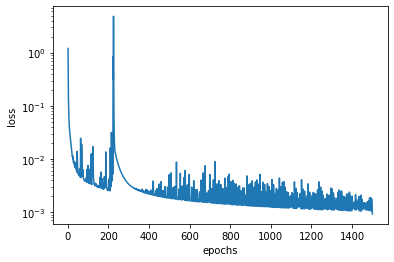

In [16]:
#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.semilogy()

## Export

In [17]:
device=torch.device('cpu')
model=model.to(device)
PATH= "model_jit_uns_cnn_3.pth"
traced_net=torch.jit.trace(model, (torch.randn(1,6400)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [3, 1, 3, 3], but got 2-dimensional input of size [1, 6400] instead

In [20]:
traced_net=torch.jit.trace(model, (torch.randn(1, 1, 80,80)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)